Import all the classes we need.

In [1]:
from PriceDataLoader import PriceDataLoader
from WeatherDataLoader import WeatherDataLoader
from models.CNN import *
import numpy as np
import statsmodels.api as sm
import pandas as pd

Plot electricity prices for three neighbouring countries

In [2]:
price_parser = PriceDataLoader(file_path="../data/european_wholesale_electricity_price_data_daily.csv")
weather_parser = WeatherDataLoader(file_path="../data/aggregated_weather.csv")

# Get countries with complete data (some countries do not have data for the entire time period)
time_range = "2015-01-01,2024-12-31"
countries_list = list(set(price_parser.get_countries_with_complete_data(time_range)) & 
                     set(weather_parser.get_country_list()))
print(f"Number of countries with complete data: {len(countries_list)}")
print(f"Countries: {countries_list}")

# Generate price matrix
price_matrix = price_parser.get_price_matrix(
    time_range=time_range, 
    countries=countries_list, 
    fill_method="ffill"
)
print(f"Shape of price_matrix: {price_matrix.shape}")
#print(f"Missing values in price_matrix:\n{price_matrix.isna().sum()}")

# Compute returns
returns = price_matrix.pct_change().dropna()
print(f"Shape of returns: {returns.shape}")

# Define weather features
weather_features = [
    'temperature_2m_mean', 'temperature_2m_min', 'temperature_2m_max',
    'precipitation_mean', 'precipitation_min', 'precipitation_max',
    'wind_speed_mean', 'wind_speed_min', 'wind_speed_max'
]
print(f"Number of total features (price + weather): {len(weather_features) * len(countries_list) + 1}")

# Generate weather matrix
weather_matrix = weather_parser.get_weather_matrix(
    time_range=time_range,
    countries=countries_list,
    fill_method="ffill",
    features=weather_features
)
print(f"Shape of weather_matrix: {weather_matrix.shape}")

Data loaded successfully from ../data/european_wholesale_electricity_price_data_daily.csv
Weather data loaded successfully from ../data/aggregated_weather.csv
Number of countries with complete data: 24
Countries: ['Czechia', 'Austria', 'Portugal', 'Norway', 'Greece', 'Denmark', 'Germany', 'Slovenia', 'Estonia', 'Spain', 'Luxembourg', 'Finland', 'Hungary', 'Sweden', 'Switzerland', 'Slovakia', 'Lithuania', 'Netherlands', 'France', 'Latvia', 'Romania', 'Belgium', 'Poland', 'Italy']
Shape of price_matrix: (3653, 24)
Shape of returns: (3652, 24)
Number of total features (price + weather): 217
Shape of weather_matrix: (3653, 216)


#### Plot the entire 2015-2024 range of prices for the three countries

Data loaded successfully from ../data/european_wholesale_electricity_price_data_daily.csv


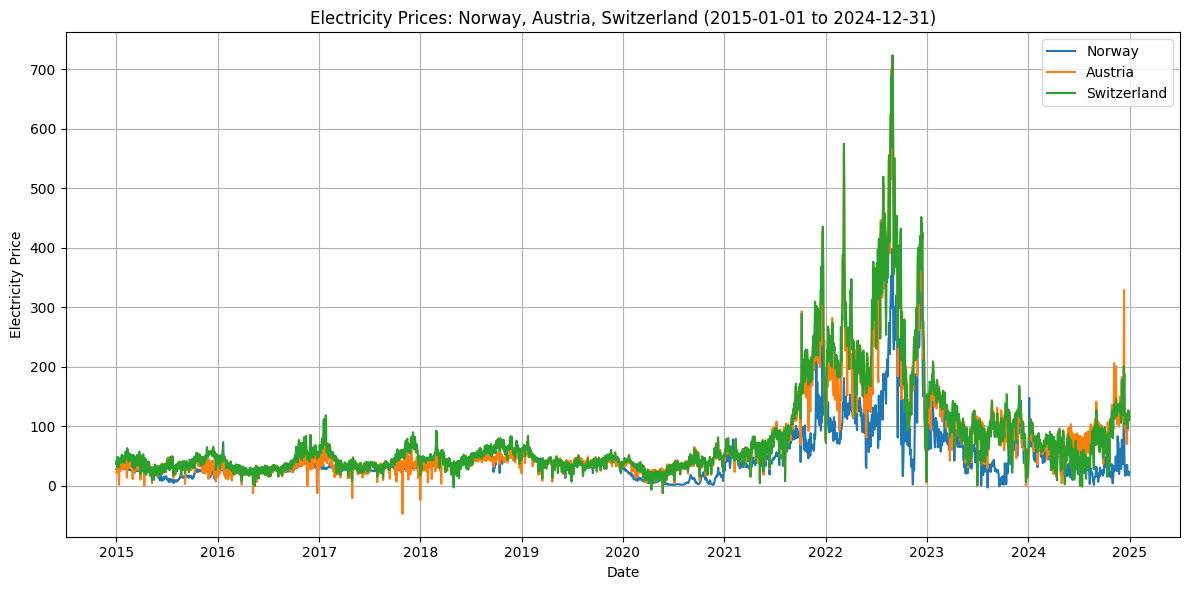

In [9]:
import matplotlib.pyplot as plt

# --- Custom time range and country selection ---
price_parser = PriceDataLoader(file_path="../data/european_wholesale_electricity_price_data_daily.csv")

# --- User input section ---
start_date = "2015-01-01"  # <-- Change as needed
end_date = "2024-12-31"    # <-- Change as needed
selected_countries = ["Norway", "Austria", "Switzerland"]  # <-- Change as needed

# --- Data extraction ---
custom_time_range = f"{start_date},{end_date}"
available_countries = list(set(price_parser.get_countries_with_complete_data(custom_time_range)))
chosen_countries = [c for c in selected_countries if c in available_countries]

if len(chosen_countries) < len(selected_countries):
    print(f"Warning: Some selected countries are not available for the chosen date range: {set(selected_countries) - set(chosen_countries)}")

price_matrix_custom = price_parser.get_price_matrix(
    time_range=custom_time_range,
    countries=chosen_countries,
    fill_method="ffill"
)

# --- Plotting ---
plt.figure(figsize=(12, 6))
for country in chosen_countries:
    plt.plot(price_matrix_custom.index, price_matrix_custom[country], label=country)
plt.xlabel("Date")
plt.ylabel("Electricity Price")
plt.title(f"Electricity Prices: {', '.join(chosen_countries)} ({start_date} to {end_date})")
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', axis='both') 
plt.show()

#### Zoom in on the first year (first cointegration window)

Data loaded successfully from ../data/european_wholesale_electricity_price_data_daily.csv


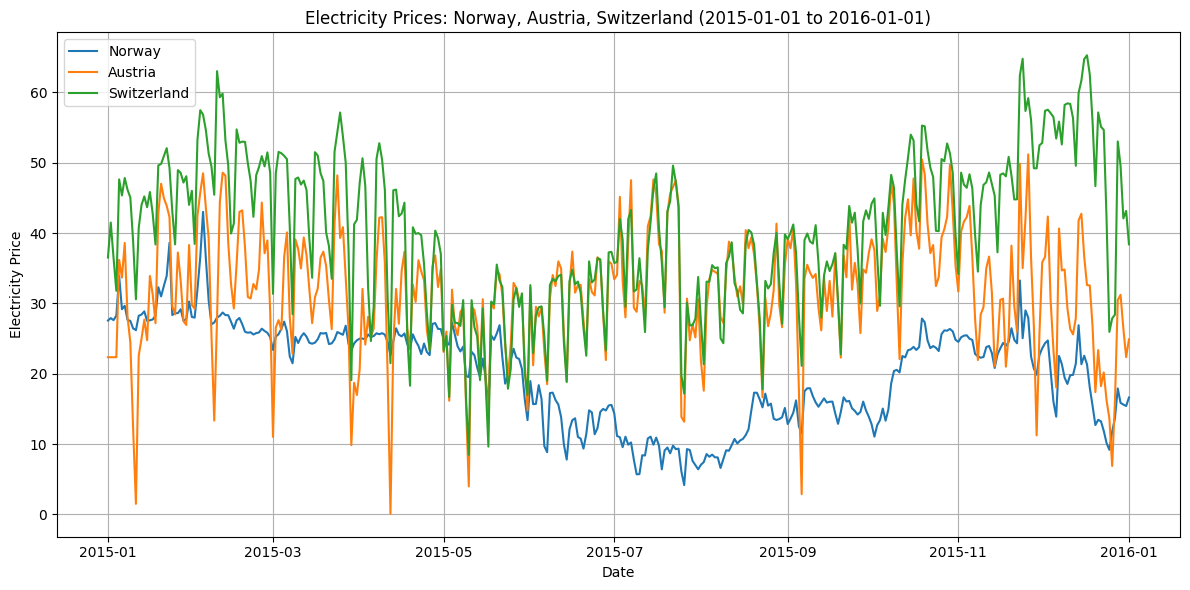

In [10]:
import matplotlib.pyplot as plt

# --- Custom time range and country selection ---
price_parser = PriceDataLoader(file_path="../data/european_wholesale_electricity_price_data_daily.csv")

# --- User input section ---
start_date = "2015-01-01"  # <-- Change as needed
end_date = "2016-01-01"    # <-- Change as needed

# --- Data extraction ---
custom_time_range = f"{start_date},{end_date}"
available_countries = list(set(price_parser.get_countries_with_complete_data(custom_time_range)))
chosen_countries = [c for c in selected_countries if c in available_countries]

if len(chosen_countries) < len(selected_countries):
    print(f"Warning: Some selected countries are not available for the chosen date range: {set(selected_countries) - set(chosen_countries)}")

price_matrix_custom = price_parser.get_price_matrix(
    time_range=custom_time_range,
    countries=chosen_countries,
    fill_method="ffill"
)

# --- Plotting ---
plt.figure(figsize=(12, 6))
for country in chosen_countries:
    plt.plot(price_matrix_custom.index, price_matrix_custom[country], label=country)
plt.xlabel("Date")
plt.ylabel("Electricity Price")
plt.title(f"Electricity Prices: {', '.join(chosen_countries)} ({start_date} to {end_date})")
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', axis='both') 
plt.show()

#### Compute the log cumulative returns

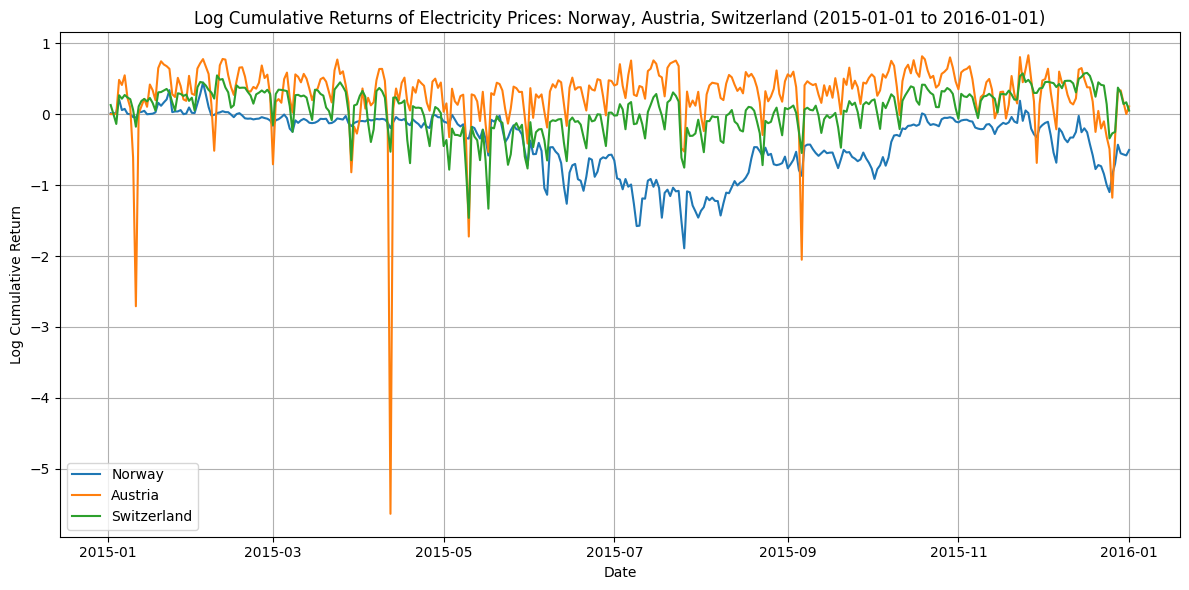

In [11]:
# --- Compute daily returns ---
returns = price_matrix_custom.pct_change().dropna()

# --- Compute cumulative returns and take log ---
cumulative_returns = (1 + returns).cumprod()
log_cumulative_returns = np.log(cumulative_returns)

# --- Plotting ---
plt.figure(figsize=(12, 6))
for country in chosen_countries:
    plt.plot(log_cumulative_returns.index, log_cumulative_returns[country], label=country)
plt.xlabel("Date")
plt.ylabel("Log Cumulative Return")
plt.title(f"Log Cumulative Returns of Electricity Prices: {', '.join(chosen_countries)} ({start_date} to {end_date})")
plt.legend()
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.show()

#### Cointegrate to get the residuals

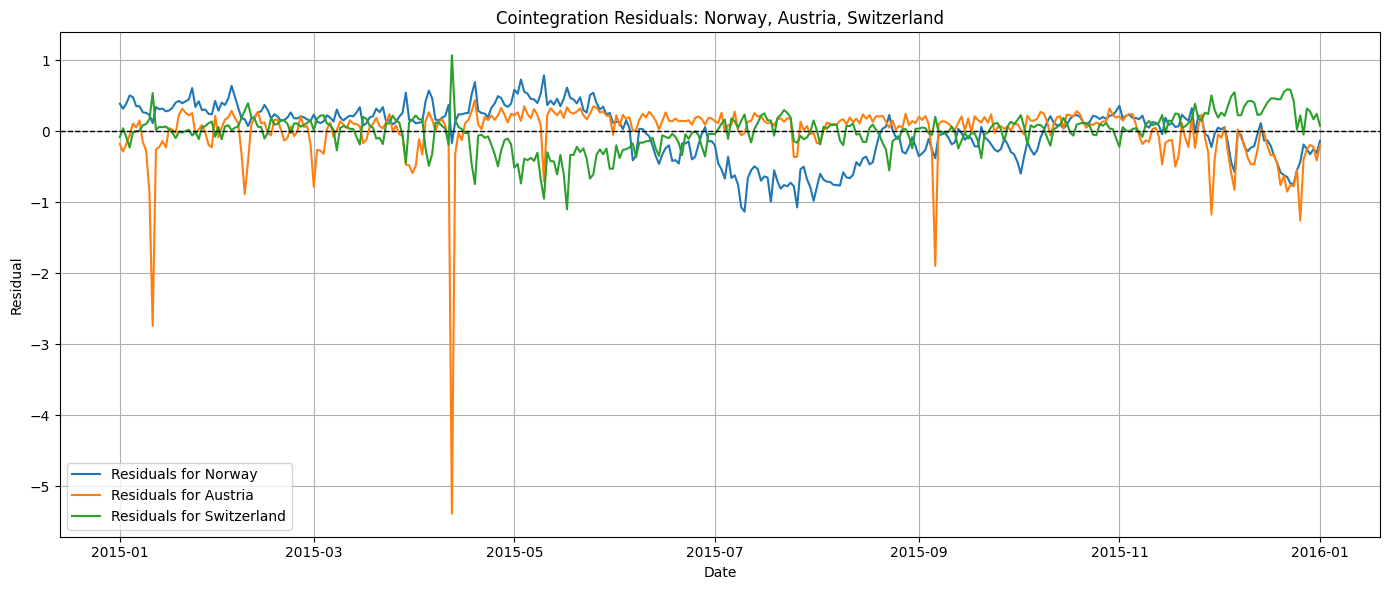

In [12]:
# Use log prices for cointegration analysis
log_prices = np.log(price_matrix_custom)

plt.figure(figsize=(14, 6))
for i, country in enumerate(chosen_countries):
    # Define dependent and independent variables
    y = log_prices[country]
    X = log_prices[[c for c in chosen_countries if c != country]]
    X = sm.add_constant(X)  # Add intercept

    # Align and drop missing values
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    X_clean = data.iloc[:, 1:]

    # Fit OLS regression
    model = sm.OLS(y_clean, X_clean).fit()
    residuals = model.resid

    # Plot all residuals on the same figure
    plt.plot(residuals.index, residuals, label=f"Residuals for {country}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"Cointegration Residuals: {', '.join(chosen_countries)}")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.show()

#### Zoom in the on the first 30-day window (first residual window) of this residual plot

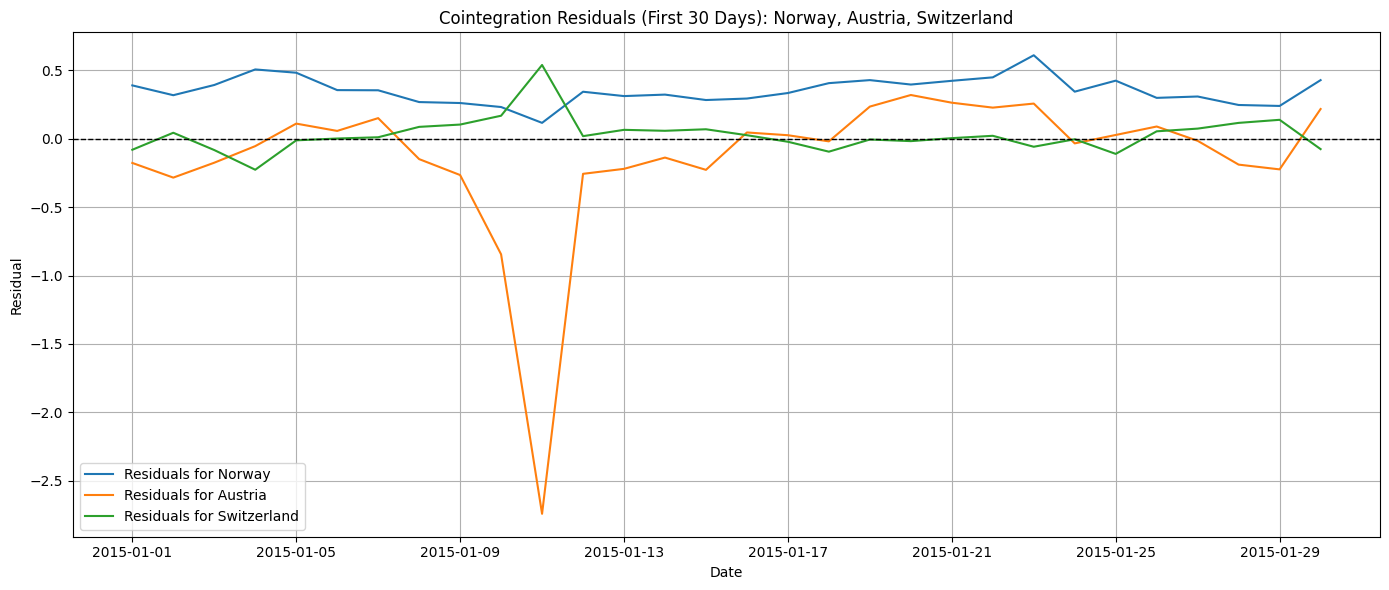

In [13]:
# Use log prices for cointegration analysis
log_prices = np.log(price_matrix_custom)

plt.figure(figsize=(14, 6))
for i, country in enumerate(chosen_countries):
    # Define dependent and independent variables
    y = log_prices[country]
    X = log_prices[[c for c in chosen_countries if c != country]]
    X = sm.add_constant(X)  # Add intercept

    # Align and drop missing values
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    X_clean = data.iloc[:, 1:]

    # Fit OLS regression
    model = sm.OLS(y_clean, X_clean).fit()
    residuals = model.resid

    # Plot only the first 30 days of residuals
    plt.plot(residuals.index[:30], residuals.iloc[:30], label=f"Residuals for {country}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"Cointegration Residuals (First 30 Days): {', '.join(chosen_countries)}")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.show()

#### Take the cumulative of the 30-day 

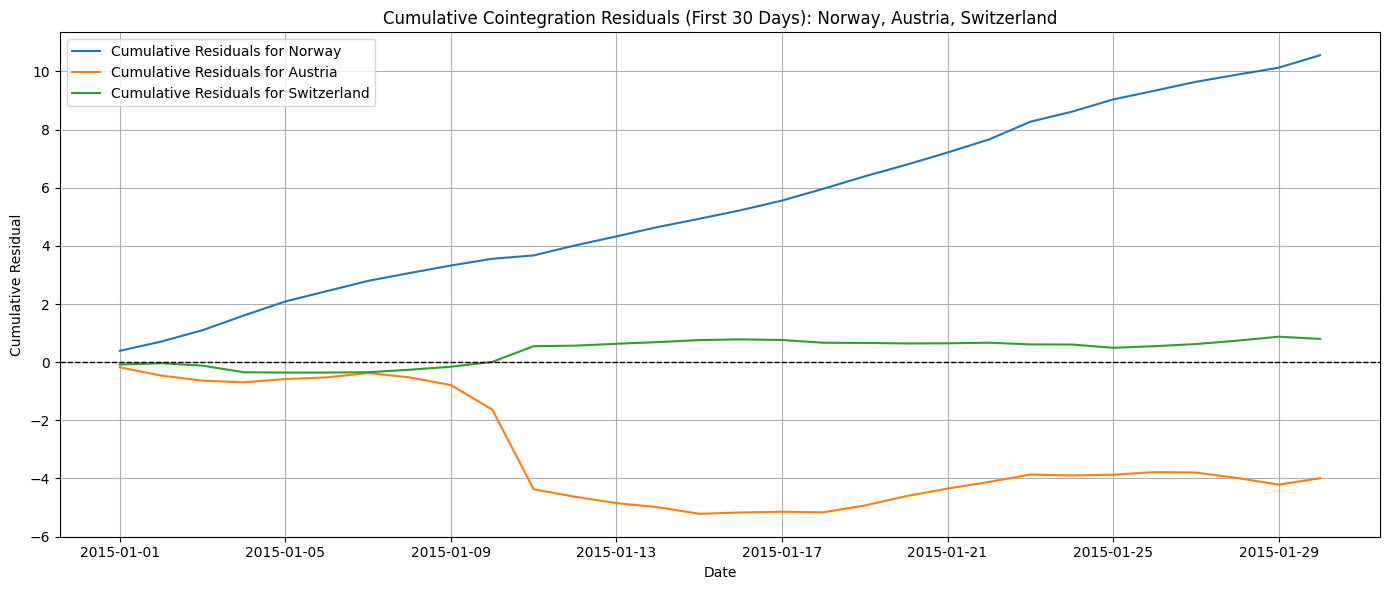

In [14]:
# Use log prices for cointegration analysis
log_prices = np.log(price_matrix_custom)

plt.figure(figsize=(14, 6))
for i, country in enumerate(chosen_countries):
    # Define dependent and independent variables
    y = log_prices[country]
    X = log_prices[[c for c in chosen_countries if c != country]]
    X = sm.add_constant(X)  # Add intercept

    # Align and drop missing values
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    X_clean = data.iloc[:, 1:]

    # Fit OLS regression
    model = sm.OLS(y_clean, X_clean).fit()
    residuals = model.resid

    # Compute cumulative residuals (cumulative sum)
    cumulative_residuals = residuals.cumsum()

    # Plot only the first 30 days of cumulative residuals
    plt.plot(cumulative_residuals.index[:30], cumulative_residuals.iloc[:30], label=f"Cumulative Residuals for {country}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"Cumulative Cointegration Residuals (First 30 Days): {', '.join(chosen_countries)}")
plt.xlabel("Date")
plt.ylabel("Cumulative Residual")
plt.legend()
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.show()

#### Normalize the cumulative residuals

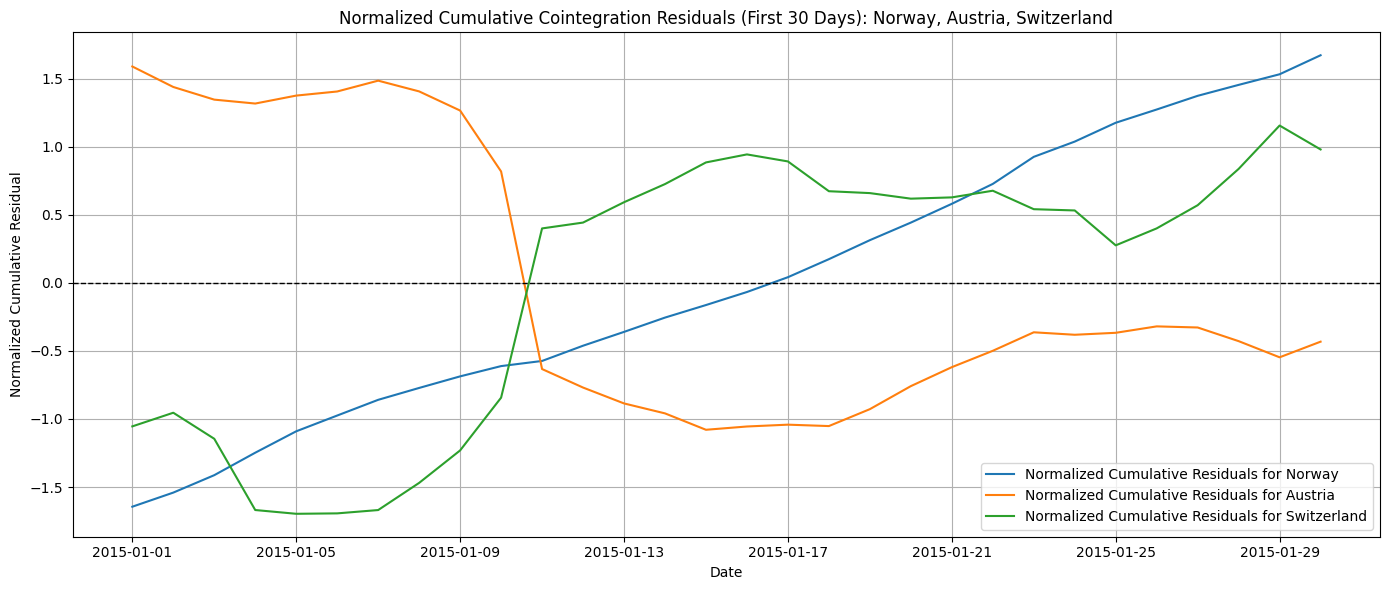

In [18]:
# Use log prices for cointegration analysis
log_prices = np.log(price_matrix_custom)

plt.figure(figsize=(14, 6))
for i, country in enumerate(chosen_countries):
    # Define dependent and independent variables
    y = log_prices[country]
    X = log_prices[[c for c in chosen_countries if c != country]]
    X = sm.add_constant(X)  # Add intercept

    # Align and drop missing values
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    X_clean = data.iloc[:, 1:]

    # Fit OLS regression
    model = sm.OLS(y_clean, X_clean).fit()
    residuals = model.resid

    # Compute cumulative residuals (cumulative sum)
    cumulative_residuals = residuals.cumsum()

    # Take only the first 30 days
    cum_resid_30 = cumulative_residuals.iloc[:30]

    # Normalize within the 30-day window
    norm_cum_resid_30 = (cum_resid_30 - cum_resid_30.mean()) / cum_resid_30.std()

    # Plot normalized cumulative residuals for the first 30 days
    plt.plot(norm_cum_resid_30.index, norm_cum_resid_30, label=f"Normalized Cumulative Residuals for {country}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"Normalized Cumulative Cointegration Residuals (First 30 Days): {', '.join(chosen_countries)}")
plt.xlabel("Date")
plt.ylabel("Normalized Cumulative Residual")
plt.legend()
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.show()